X.shape = (1797, 8, 8)
y.shape = (1797,)


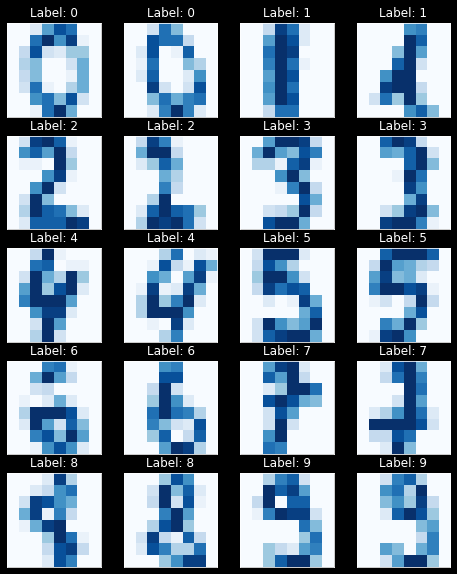

In [1]:
# Get the data
from sklearn.datasets import load_digits
import numpy as np

digit = load_digits()
X, y = digit.images, digit.target

print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')

# Visualize the data
def sample(X, y, samples):
    unique_ys = np.unique(y, axis=0)
    result = []
    for unique_y in unique_ys:
        val_indices = np.argwhere(y==unique_y).flatten()
        random_samples = np.random.choice(val_indices, samples, replace=False)
        result.extend(map(lambda x:(x, unique_y), X[random_samples]))
    return result
    

_X = sample(X, y, 2)

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('dark_background')

fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(8, 10))
axs = axs.flatten()
for ax, (a, b) in zip(axs, _X):
    ax.imshow(a, cmap='Blues')
    ax.set_title(f'Label: {b}')
    ax.tick_params(
        left=False,
        labelleft=False,
        labelbottom=False,
        bottom=False
    )

plt.show()

In [2]:
# Partition the training and testing data
from neural_network.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'X_test.shape  = {X_test.shape}')
print(f'y_test.shape  = {y_test.shape}')

X_train.shape = (1348, 8, 8)
y_train.shape = (1348,)
X_test.shape = (449, 8, 8)
y_test.shape = (449,)


In [3]:
# Expand dimensions for convolutions
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape  = {X_test.shape}')

X_train.shape = (1348, 1, 8, 8)
X_test.shape = (449, 1, 8, 8)


In [4]:
# One Hot Encode the labels
from neural_network.preprocess import OneHotEncoder

labels = np.unique(y)
print(f'{labels = }\n')  # Unique labels

encoder = OneHotEncoder().fit(labels)
y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

print(f'y_train_encoded.shape = {y_train_encoded.shape}')  # Encoded training labels
print(f'y_test_encoded.shape  = {y_test_encoded.shape}')   # Encoded testing labels

labels = array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

y_train_encoded.shape = (1348, 10)
y_test_encoded.shape = (449, 10)


In [5]:
# Define a sequential model
from neural_network.model import Sequential

net = Sequential()

In [6]:
#  Add layers to the model
from neural_network.layers import Dense, Flatten, Convolutional

net.add(
    Convolutional(25, 3, input_shape=(1, 8, 8), activation='tanh'),
    Flatten(),
    Dense(128, activation='tanh'),
    Dense(64, activation='leaky_relu'),
    Dense(10, activation='softmax')
)

In [7]:
# Compile and build  the model
net.compile(cost='crossentropy', metrics=['accuracy_score'])

net.summary()

Sequential Model: 'Sequential Model' with 5 layers
Input Shape: (1, 8, 8)
----------------------------------------------------------------------------------
| # |     Layer     |                            Info                            |
----------------------------------------------------------------------------------
| 1 | Convolutional | Convolutional Layer with 25 filters, 1 channel, 3x3 kernel |
| 2 |    Flatten    |                       Flatten Layer                        |
| 3 |     Dense     |                 Dense Layer with 128 nodes                 |
| 4 |     Dense     |                 Dense Layer with 64 nodes                  |
| 5 |     Dense     |                 Dense Layer with 10 nodes                  |
----------------------------------------------------------------------------------
Total Trainable Params = 125,359
Total Non-Trainable Params = 0


In [8]:
# Initialize cross validator
from neural_network.model_selection import KFold

kf = KFold(n_splits=5)

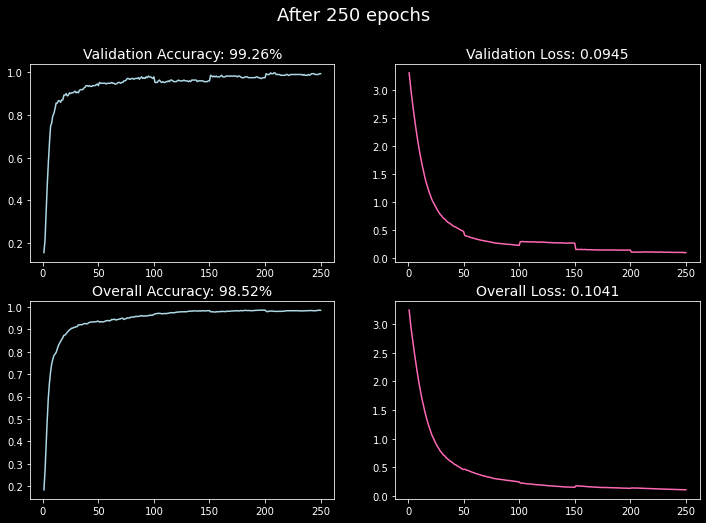

In [9]:
# Train the model with Cross Validation
from IPython.display import display, clear_output
clear_output(wait=False)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

ax1.set_title('Validation Accuracy')
ax2.set_title('Validation Loss')
ax3.set_title('Overall Accuracy')
ax4.set_title('Overall Loss')

for ax in (ax1, ax3):
    ax.set_ylabel('Accuracy')
for ax in (ax2, ax4):
    ax.set_ylabel('Loss')
for ax in (ax1, ax3, ax3, ax4):
    ax.set_xlabel('Epochs')

overall_accuracy = []
overall_loss = []
validation_accuracy = []
validation_loss = []

update_frequency = 5
count = 0

for train, validate in kf.split(X_train):
    for data in net.fit(
        X_train[train],
        y_train_encoded[train],
        epochs=50,
        batch_size=128,
        validation_data=(X_train[validate], y_train_encoded[validate]),
        verbose=False, # The output is huge otherwise
        get_trainer=True, # Get trainer generator instead of training
    ):
        overall_accuracy.append(data['overall']['accuracy'])
        overall_loss.append(data['overall']['loss'])
        validation_accuracy.append(data['validation']['accuracy'])
        validation_loss.append(data['validation']['loss'])
        count += 1

        if count % update_frequency != 0:
            continue
        
        fig.suptitle(f'After {count} epochs', fontsize=18)

        for ax in (ax1, ax2, ax3, ax4):
            ax.cla()
        
        ax1.plot(np.arange(len(validation_accuracy)) + 1, validation_accuracy, color='lightblue')
        ax1.set_title(f'Validation Accuracy: {np.around(validation_accuracy[-1] * 100, 2)}%', fontsize=14)
        ax2.plot(np.arange(len(validation_loss)) + 1, validation_loss, color='hotpink')
        ax2.set_title(f'Validation Loss: {np.around(validation_loss[-1], 4)}', fontsize=14)
        ax3.plot(np.arange(len(overall_accuracy)) + 1, overall_accuracy, color='lightblue')
        ax3.set_title(f'Overall Accuracy: {np.around(overall_accuracy[-1] * 100, 2)}%', fontsize=14)
        ax4.plot(np.arange(len(overall_loss)) + 1, overall_loss, color='hotpink')
        ax4.set_title(f'Overall Loss: {np.around(overall_loss[-1], 4)}', fontsize=14)
        
        clear_output(wait=False)
        display(fig)
        plt.pause(0.1)

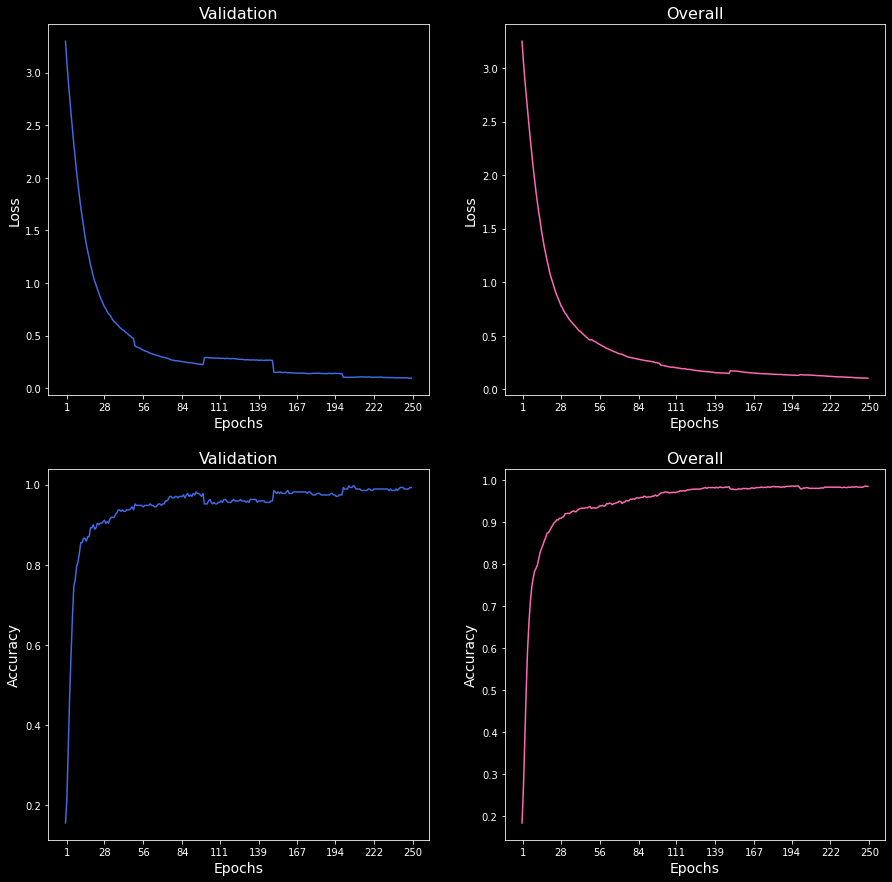

In [10]:
# Plot model's learning via accuracy and loss

validation_history = net.history['validation']
model_history = net.history['overall']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

ax1.plot(
    np.arange(len(validation_history['loss'])),
    validation_history['loss'],
    color='royalblue'
)
ax2.plot(
    np.arange(len(model_history['loss'])),
    model_history['loss'],
    color='hotpink'
)
ax3.plot(
    np.arange(len(validation_history['accuracy_score'])),
    validation_history['accuracy_score'],
    color='royalblue'
)
ax4.plot(
    np.arange(len(model_history['accuracy_score'])),
    model_history['accuracy_score'],
    color='hotpink'
)

for ax in (ax1, ax2):
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)

for ax in (ax3, ax4):
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)

    
for ax in (ax1, ax2, ax3, ax4):
    ax.set_xticks(np.linspace(1, len(model_history['loss']), 10, dtype=int))
    ax.set_xticklabels(map(str, np.linspace(1, len(model_history['loss']), 10, dtype=int)))

ax1.set_title('Validation', fontsize=16)
ax2.set_title('Overall', fontsize=16)
ax3.set_title('Validation', fontsize=16)
ax4.set_title('Overall', fontsize=16)

plt.show()

In [11]:
# Make predictions on the testing data
predictions = net.predict(X_test, classify=True)

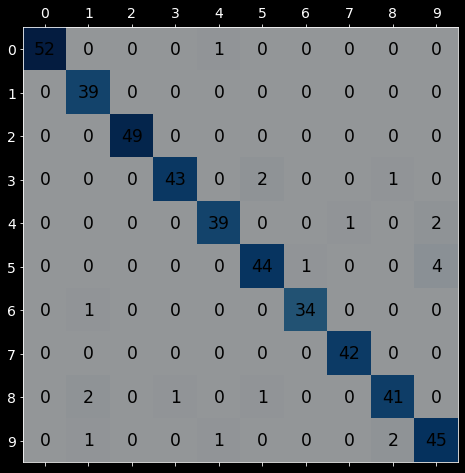

In [12]:
# The confusion matrix
from neural_network.metrics import confusion_matrix
cmat = confusion_matrix(y_test_encoded, predictions) 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

ax.matshow(cmat, cmap='Blues', alpha=0.6)
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(map(str, labels), fontsize=14)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(map(str, labels), fontsize=14)

for i in range(cmat.shape[0]):
    for j in range(cmat.shape[1]):
        ax.text(x=j, y=i, s=cmat[i, j], va='center', 
                ha='center', size='xx-large', color='black')

In [13]:
# Accuracy of the model
from neural_network.metrics import accuracy_score

acc = accuracy_score(y_test_encoded, predictions)
print(f'Testing Accuracy: {np.around(acc * 100, 3)}%')

Testing Accuracy: 95.323%


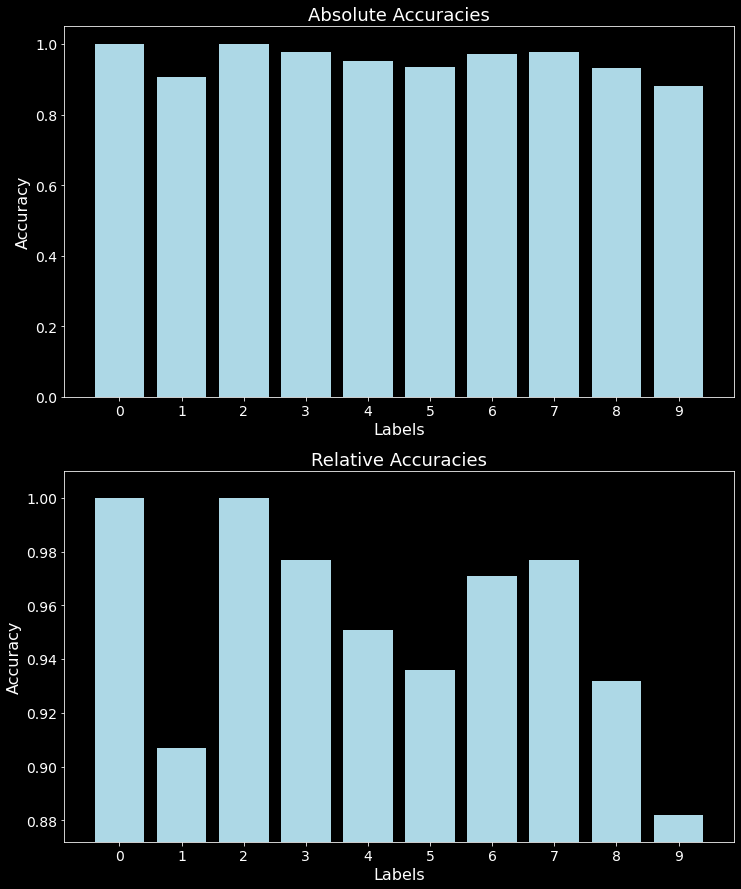

In [14]:
# Accuracy by label
from neural_network.metrics import accuracy_by_label
acc_by_label = accuracy_by_label(y_test_encoded, predictions)
acc_by_label = np.around(acc_by_label, 3)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 15))

ax1.bar(np.arange(len(acc_by_label)), acc_by_label, color='lightblue')
ax1.set_xticks(np.arange(len(acc_by_label)))
ax1.set_xticklabels(map(str, labels))
ax1.set_xlabel('Labels', fontsize=16)
ax1.set_ylabel('Accuracy', fontsize=16)
ax1.set_title('Absolute Accuracies', fontsize=18)
ax1.tick_params(axis='both', labelsize=14)

ax2.bar(np.arange(len(acc_by_label)), acc_by_label, color='lightblue')
ax2.set_xticks(np.arange(len(acc_by_label)))
ax2.set_xticklabels(map(str, labels))
ax2.set_xlabel('Labels', fontsize=16)
ax2.set_ylabel('Accuracy', fontsize=16)
ax2.set(ylim=[acc_by_label.min() - 0.01, acc_by_label.max() + 0.01])
ax2.set_title('Relative Accuracies', fontsize=18)
ax2.tick_params(axis='both', labelsize=14)

plt.show()

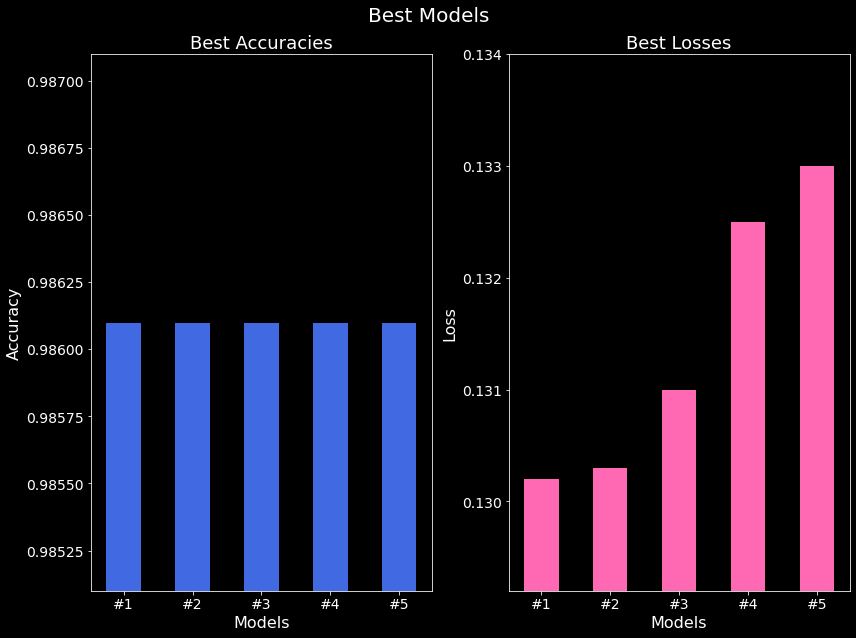

In [15]:
best_models = net.checkpoints

best_accuracies = np.around([acc for _, acc, _ in best_models], 4)
best_losses = np.around([loss for _, _, loss in best_models], 4)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 9))

fig.suptitle('Best Models', fontsize=20)

ax1.bar(np.arange(len(best_accuracies), dtype=int) + 1, best_accuracies, color='royalblue', width=0.5)
ax1.set_title('Best Accuracies', fontsize=18)
ax1.set_xlabel('Models', fontsize=16)
ax1.set_ylabel('Accuracy', fontsize=16)
ax1.set_xticks(np.arange(len(best_accuracies), dtype=int) + 1)
ax1.set_xticklabels(map(lambda x: f'#{x}', np.arange(len(best_accuracies), dtype=int) + 1))
ax1.set(ylim=[min(best_accuracies) - 0.001, max(best_accuracies) + 0.001])
ax1.tick_params(axis='both', labelsize=14)

ax2.bar(np.arange(len(best_losses), dtype=int) + 1, best_losses, color='hotpink', width=0.5)
ax2.set_title('Best Losses', fontsize=18)
ax2.set_xlabel('Models', fontsize=16)
ax2.set_ylabel('Loss', fontsize=16)
ax2.set_xticks(np.arange(len(best_losses), dtype=int) + 1)
ax2.set_xticklabels(map(lambda x: f'#{x}', np.arange(len(best_losses), dtype=int) + 1))
ax2.set(ylim=[min(best_losses) - 0.001, max(best_losses) + 0.001])
ax2.tick_params(axis='both', labelsize=14)

fig.tight_layout()
plt.show()